In [1]:
import numpy as np
from PIL import Image
# import imageio
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, Conv2DTranspose, Flatten
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
import glob

In [2]:
def read_image(item, mask):
  if mask==True:
    image=cv2.imread(item, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (128,128))
    # 
    new_image=np.zeros((128,128,9))
    for i in range(9):
      if i>0:
        array = np.where(image==i)
        for index,tuple in enumerate(array[0]):
          new_image[array[0][index]][array[1][index]][i]=1
    return new_image
    # return image
  else:
    image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (128, 128))
    # rgb images
    # return image[:,:,:3]

    # thermal images
    # return image[:,:,-1:]

    # # rgb+thermal
    return image

In [3]:
# remove images that don't have a mask
img_dir = sorted(os.listdir("ir_seg_dataset/images/"))
label_dir = sorted(os.listdir("ir_seg_dataset/labels/"))
new_img_dir=[]
for item in img_dir:
    # print("analyzing: ", item)
    if item in label_dir:
        new_img_dir.append(item)
# print(len(new_img_dir))

In [4]:
# img_dir = sorted(glob.glob("ir_seg_dataset/images/*.png"))
mask_dir = sorted(glob.glob("ir_seg_dataset/labels/*.png"))
# print(mask_dir)
all_images = []
all_masks = []
for item in tqdm(new_img_dir):
    image = read_image("ir_seg_dataset/images/"+item, mask=False)
    # image = read_image("ir_seg_dataset/images/"+item)
    all_images.append(image)

100%|██████████| 1569/1569 [00:20<00:00, 78.41it/s] 


In [5]:
for item in tqdm(mask_dir):
    mask = read_image(item, mask=True)
    # mask = read_image(item)
    all_masks.append(mask)
    # print(item)

100%|██████████| 1569/1569 [00:03<00:00, 394.21it/s]


In [6]:
print(all_images[0].shape)
x_data = np.stack(all_images, axis=0)/255
y_data = np.stack(all_masks, axis=0).astype(int)

(128, 128, 4)


In [7]:
print(x_data.min(), x_data.max())
print(y_data[0].min(), y_data[0].max())
print(x_data[0].min(), x_data[0].max())

0.0 1.0
0 1
0.0 1.0


In [8]:
# print object shapes
print(x_data.shape)
print(y_data.shape)

(1569, 128, 128, 4)
(1569, 128, 128, 9)


444


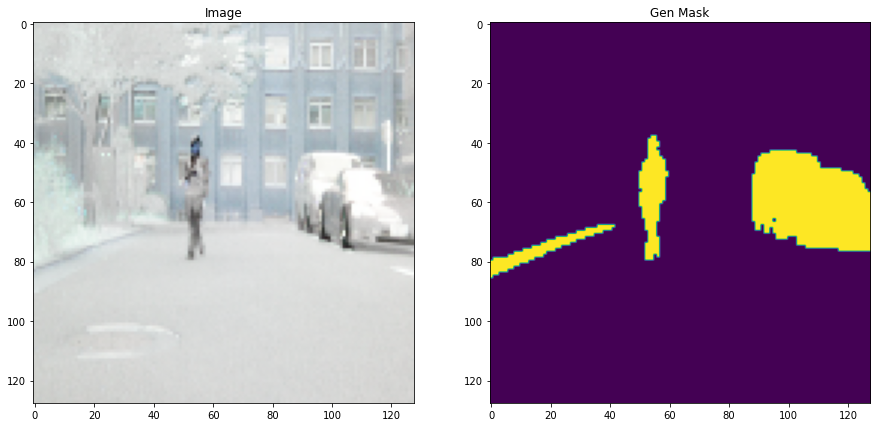

In [13]:
# show exemplary mask
fig = plt.figure(figsize=(15, 10))
rows = 1
columns =2
i=np.random.randint(len(new_img_dir))
# i=449
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(x_data[i])
plt.title("Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
# plt.imshow(y_data[i][:,:,1])
avg_img = np.sum(y_data[i], axis=2)
plt.imshow(avg_img)
plt.title("Gen Mask")

print(i)

In [9]:
all_indices = np.arange(0, len(x_data))
np.random.shuffle(all_indices)
TEST_FRAC = 0.1
test_indices = all_indices[0:int(len(x_data)*TEST_FRAC)]
train_indices = all_indices[int(len(x_data)*TEST_FRAC):]
x_train = x_data[train_indices]
y_train = y_data[train_indices]
x_test = x_data[test_indices]
y_test = y_data[test_indices]

In [10]:
#clear RAM
all_images=[]
all_masks=[]
x_data=[]
y_data=[]
all_indices=[]
test_indices=[]
train_indices=[]

In [11]:
class NonNegative(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)

class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination, self).__init__()
        self.is_train=is_train

    def build(self, input_shape):
        self.filt=1
        self.size=(1,1)
        self.stride=1
        self.pad="same"
        self.bias=False
        self.initializer=tf.keras.initializers.Constant(0.5)
        self.conv2d=tf.keras.layers.Conv2D(filters=self.filt, kernel_size=self.size, strides=self.stride, padding=self.pad, 
                                           use_bias=self.bias, kernel_initializer=self.initializer, kernel_constraint=NonNegative())
    
    def call(self, inputs):
        return self.conv2d(inputs)

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, MaxPooling2D, BatchNormalization

def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [18]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32, dropout_prob=0.3):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input])
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    if dropout_prob>0:
        conv = Dropout(dropout_prob)(conv)
    return conv

In [19]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=2, illumination=False):
    inputs = Input(input_size)
    if illumination==True:
        illu=Illumination(is_train=True)(inputs)
    else:
        illu=inputs

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(illu, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.5, max_pooling=True)

    #bottleneck
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8, dropout_prob=0)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4, dropout_prob=0)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2, dropout_prob=0)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters, dropout_prob=0.5)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [12]:
from keras import backend as K
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = 2 * tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

In [21]:
unet = UNetCompiled(input_size=(128,128,4), n_filters=32, n_classes=9, illumination=False)
unet.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[dice_coefficient])
unet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
# unet.layers[1].get_weights()

[array([[[[-3.16535026e-01, -6.47146463e-01,  3.93605679e-01,
            5.37145495e-01,  1.08370118e-01,  3.44426990e-01,
            8.30918103e-02, -2.37830225e-02,  1.08992562e-01,
           -2.29813680e-02,  4.42528054e-02,  9.46431756e-01,
           -1.02448976e-02, -3.03108096e-01, -2.12753803e-01,
            2.94826794e-02, -4.10580695e-01, -2.36667857e-01,
           -4.05360907e-01, -3.45775098e-01, -1.25294507e-01,
            8.43723178e-01,  4.70918901e-02,  4.14711714e-01,
           -7.30504513e-01, -4.27900612e-01,  3.10103208e-01,
            4.55701262e-01,  6.85567796e-01, -7.14768231e-01,
           -6.61355674e-01, -5.26792884e-01]],
 
         [[ 3.58746231e-01,  6.78279817e-01,  5.77399790e-01,
            5.03532350e-01,  1.60732009e-02, -9.36099663e-02,
            1.78852901e-01, -4.12202656e-01, -1.46244630e-01,
            2.74867862e-01, -3.34259897e-01, -1.89521849e-01,
           -8.55581544e-04,  2.46988028e-01, -1.93852529e-01,
            4.1461429

In [19]:
# bad_pred = unet.predict(x_test[0:1])[0]

In [22]:
checkpoint_path = "training_models/multi/my_best_model.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", patience=15, verbose=0, mode='max', restore_best_weights='True')
mcp_save = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_dice_coefficient", mode='max')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", factor=0.1, patience=10, verbose=1, mode='max')

history = unet.fit(x_train, y_train, epochs=100, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(x_test, y_test))

Epoch 1/100
45/45 [==============================] - 21s 267ms/step - loss: 0.1161 - dice_coefficient: 0.0520 - val_loss: 0.1291 - val_dice_coefficient: 0.0440
Epoch 2/100
45/45 [==============================] - 8s 186ms/step - loss: 0.0398 - dice_coefficient: 0.1172 - val_loss: 0.0687 - val_dice_coefficient: 0.0594
Epoch 3/100
45/45 [==============================] - 8s 185ms/step - loss: 0.0370 - dice_coefficient: 0.1470 - val_loss: 0.0422 - val_dice_coefficient: 0.0619
Epoch 4/100
45/45 [==============================] - 8s 185ms/step - loss: 0.0347 - dice_coefficient: 0.1725 - val_loss: 0.0421 - val_dice_coefficient: 0.0690
Epoch 5/100
45/45 [==============================] - 8s 185ms/step - loss: 0.0336 - dice_coefficient: 0.2010 - val_loss: 0.0428 - val_dice_coefficient: 0.0613
Epoch 6/100
45/45 [==============================] - 8s 185ms/step - loss: 0.0305 - dice_coefficient: 0.2474 - val_loss: 0.0384 - val_dice_coefficient: 0.0552
Epoch 7/100
45/45 [==========================

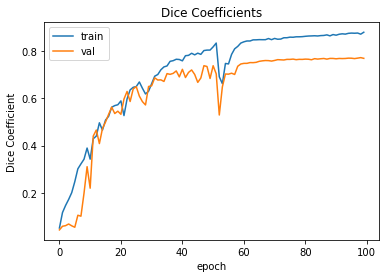

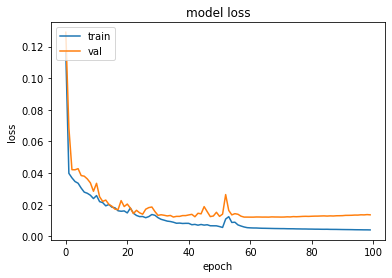

In [23]:
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Dice Coefficients')
plt.ylabel('Dice Coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
dependencies = {
    'dice_coefficient': dice_coefficient
}
checkpoint_path = "training_models/multi/my_best_model.hdf5"
unet=keras.models.load_model(checkpoint_path, custom_objects=dependencies)

val_loss, val_dice_coefficient = unet.evaluate(x_test, y_test, verbose=2)
print("Restored model, val_dice_coefficient: {:5.2f}%".format(100 * val_dice_coefficient))

5/5 - 5s - loss: 0.0052 - dice_coefficient: 0.8687
Restored model, val_dice_coefficient: 86.87%


(128, 128, 9)


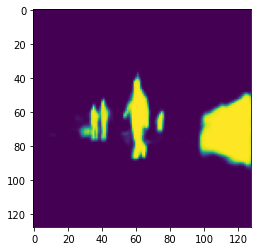

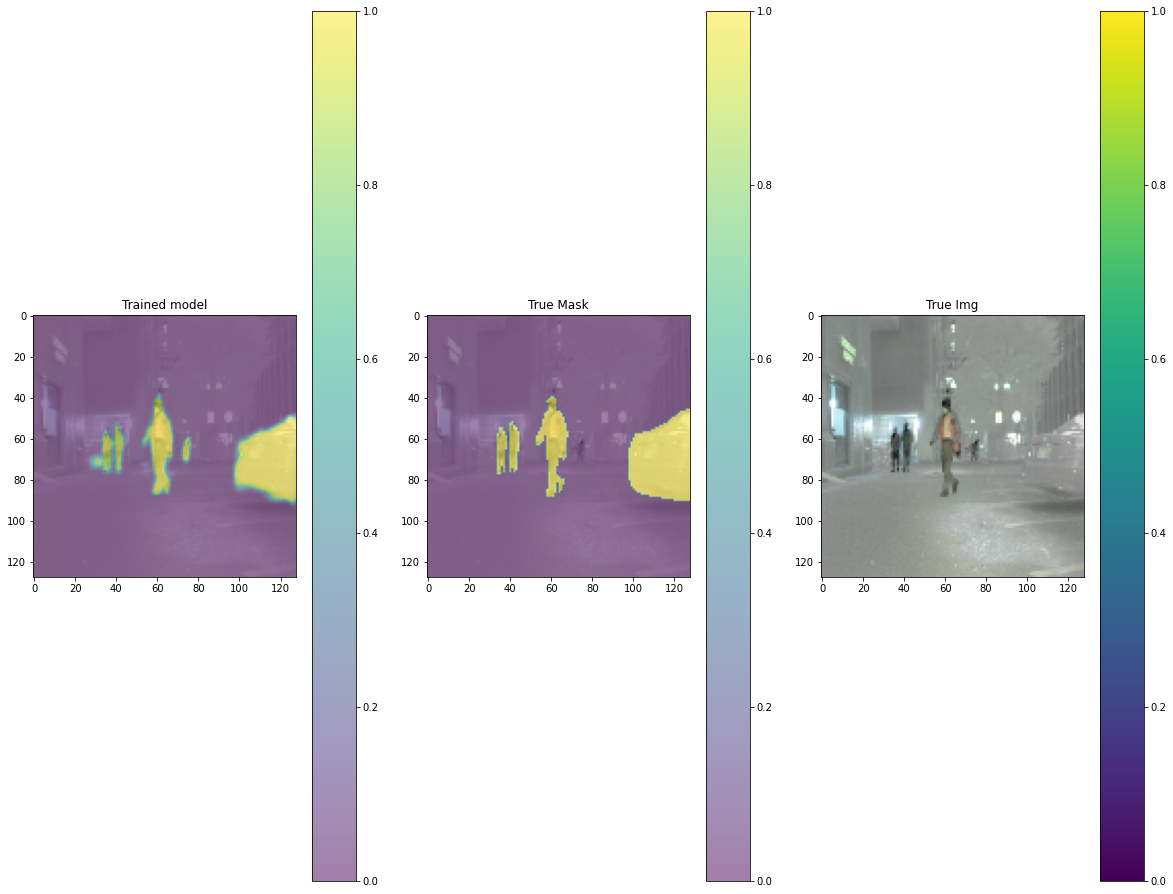

In [35]:
i=6
j=i+1
img= x_test[i:j]
pred_y = unet.predict(img)[0]
print(pred_y.shape)
# plt.imshow(pred_y[:,:,6])
# pred_mask = tf.argmax(pred_y, axis=-1)
# pred_mask = pred_mask[..., tf.newaxis]
# good_pred=pred_mask
avg_img = np.sum(pred_y, axis=2)

plt.imshow(avg_img)


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
# axs[0].set_title("Untrained model")
# axs[0].imshow(x_test[i], cmap=plt.cm.gray)
# im = axs[0].imshow(bad_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[0])

axs[0].set_title("Trained model")
axs[0].imshow(x_test[i], cmap=plt.cm.gray)
im = axs[0].imshow(avg_img, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0])

true_mask=np.sum(y_test[i:j][0], axis=2)
axs[1].set_title("True Mask")
axs[1].imshow(x_test[i], cmap=plt.cm.gray)
im = axs[1].imshow(true_mask, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1])

axs[2].set_title("True Img")
axs[2].imshow(x_test[i], cmap=plt.cm.gray)
im = axs[2].imshow(x_test[i:j][0])
plt.colorbar(im, ax=axs[2])

In [14]:
import pandas as pd
pred_imgs = unet.predict(x_test)
dc_list=[]
pred_mask=[]
true_mask=[]
true_img=[]

dc_scores = pd.DataFrame(columns=['dice_coefficient', 'pred_mask', 'true_mask', "true_img"])

for i, item in enumerate(pred_imgs):
    dc = tf.keras.backend.eval(dice_coefficient(item, y_test[i]))
    dc_list.append(dc)
    pred_mask.append(item)
    true_mask.append(y_test[i])
    true_img.append(x_test[i])
    # if dc > np.min(top5) and len(top5)<5:
    #     top5.append(tuple([item, y_test[i]]))
    #     top5.remove(np.min(top5))
    # if dc < np.max(bottom5) and len(top5)<5:
    #     bottom5.append(tuple([item, y_test[i]]))
    #     bottom5.remove(np.max(bottom5))

    print(dc)

dc_scores['dice_coefficient'] = dc_list
dc_scores['pred_mask'] = pred_mask
dc_scores['true_mask'] = true_mask
dc_scores['true_img'] = true_img
dc_scores

0.6040133204494207
0.6534695555808763
0.9343499073846195
0.9215461698469916
0.813607116736895
0.9110001080438072
0.8662956180650205
0.5123529587931636
0.8368860831115377
0.8364484490406674
0.7500339905411789
0.8053964702759754
0.9387401736588138
0.331171038334514
0.5061459350081862
0.7783196908761519
0.8699495046089895
0.867513308737192
0.7743716279572499
0.8856766567571194
0.8998415540580139
0.9069344256235582
0.8651367862815249
0.6529046905110942
0.5381017160117879
0.9441629305332295
0.8541754707677934
0.49917069726870206
0.5979489482204484
0.8968675828973365
0.9191208598185998
0.7340530910929307
0.7300567158879793
0.8375223758220727
0.5255870038583691
0.681584846529126
0.8696335534025391
0.9189746276160274
0.7654302474622396
0.7365023820601657
0.7028658520007444
0.9326796534638706
0.6235577002594103
0.8549328982909323
0.8631200057146424
0.6781813259917281
0.9235546278152249
0.8872449059004235
0.8533443195135235
0.8485178428847696
0.9405019133779816
0.8375470123752143
0.8543694349695

,dice_coefficient,pred_mask,true_mask,true_img
0,0.604013,"[[[2.0383569e-13, 1.2718407e-05, 1.0184925e-06...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.07450980392156863, 0.19215686274509805, 0..."
1,0.653470,"[[[3.7890948e-14, 4.5785846e-06, 4.580309e-07,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.23137254901960785, 0.21176470588235294, 0..."
2,0.934350,"[[[4.928362e-19, 6.661425e-08, 1.8928719e-09, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.12941176470588237, 0.1803921568627451, 0...."
3,0.921546,"[[[5.1467824e-20, 2.2501883e-08, 3.350888e-10,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.9137254901960784, 0.984313725490196, 0.97..."
4,0.813607,"[[[1.2304487e-14, 3.6004756e-06, 3.0553983e-07...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.00784313725490196, 0.03529411764705882, 0..."
...,...,...,...,...
151,0.958983,"[[[4.9077685e-17, 6.282633e-07, 2.5894913e-08,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.10196078431372549, 0.12156862745098039, 0..."
152,0.743026,"[[[1.7566338e-09, 0.00040330796, 6.7046196e-05...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.25882352941176473, 0.25098039215686274, 0..."
153,0.961400,"[[[3.2264966e-14, 6.75873e-06, 3.7180945e-07, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.23529411764705882, 0.2901960784313726, 0...."
154,0.957024,"[[[2.9553647e-15, 1.6055294e-06, 9.2068646e-08...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.9058823529411765, 0.9686274509803922, 0.9..."


In [15]:
dc_scores = dc_scores.sort_values(by="dice_coefficient")

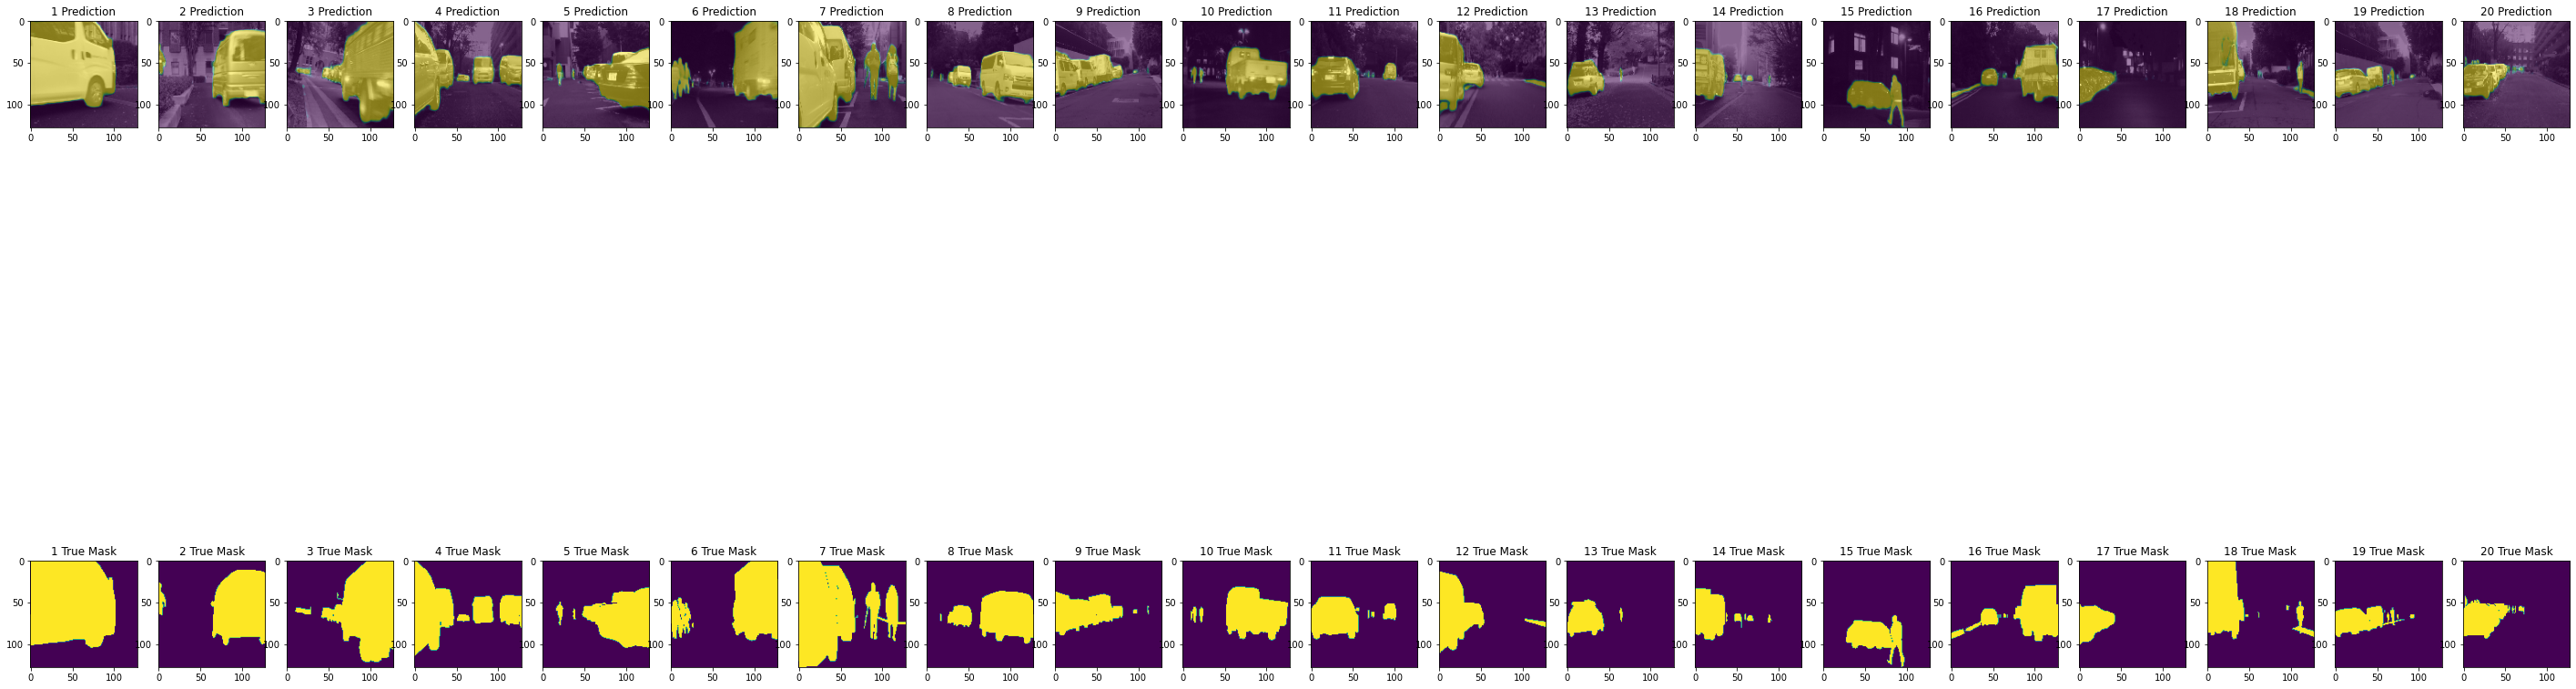

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=20, figsize=(50, 20))
for i in range(0,20):
    axs[0,i].set_title("{} Prediction".format(i+1))
    axs[0,i].imshow(np.sum(dc_scores.iloc[-(i+1)]['true_img'], axis=-1), cmap=plt.cm.gray)
    im = axs[0,i].imshow(np.sum(dc_scores.iloc[-(i+1)]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

    axs[1,i].set_title("{} True Mask".format(i+1))
    im = axs[1,i].imshow(np.sum(dc_scores.iloc[-(i+1)]['true_mask'], axis=-1))

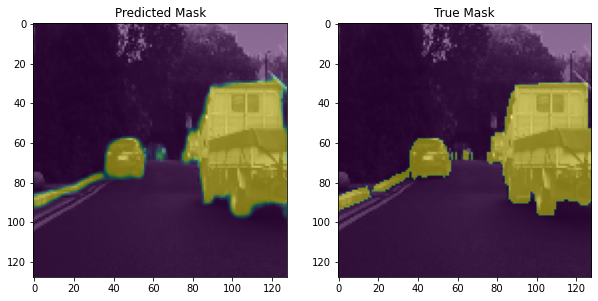

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axs[0].set_title("Predicted Mask")
axs[0].imshow(np.sum(dc_scores.iloc[-16]['true_img'], axis=-1), cmap=plt.cm.gray)
im = axs[0].imshow(np.sum(dc_scores.iloc[-16]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

axs[1].set_title("True Mask")
axs[1].imshow(np.sum(dc_scores.iloc[-16]['true_img'], axis=-1), cmap=plt.cm.gray)
im = axs[1].imshow(np.sum(dc_scores.iloc[-16]['true_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)